In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import toml
import glob
import os
pd.options.mode.chained_assignment = None  # default='warn'
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from presentation.pipelines.steps.load_data import build_loader
from presentation.pipelines.steps.model_design import load_pt_model 

from src.utils import get_metrics

%load_ext autoreload
%autoreload 2

2024-07-16 14:19:12.255426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def get_info_from_path(path, clf=False):
    factors = curr.split('/')
    info = {
        'ds_name': factors[6],
        'fold_n': int(factors[7].split('_')[-1]),
        'spc': int(factors[8].split('_')[-1]),
        'factors': factors[9] if clf else None
    }
    return info
def get_label(row, features_spec):
    label = []
    for f in features_spec:
        label.append(str(row[f]))
    label = '_'.join(label)
    return label

zero_alcock = {'20':0.27, '100':0.59}
zero_atlas = {'20':0.54, '100':0.56}

In [4]:
paths = glob.glob(os.path.join('./presentation/results/', '*', '*'))
paths

['./presentation/results/maogat/2024-07-05_14-22-52',
 './presentation/results/maogat/2024-06-02_04-10-22',
 './presentation/results/maogat/2024-06-02_04-19-29',
 './presentation/results/maogat/2024-06-02_04-18-39',
 './presentation/results/paper/2024-07-09_02-27-29',
 './presentation/results/classic/2024-07-02_22-29-44',
 './presentation/results/classic/2024-06-24_17-31-29',
 './presentation/results/classic/2024-07-02_22-31-31']

## Pretraining

In [5]:
config_list = []
for curr_path in paths:
    
    try:
        rmse_df = get_metrics(os.path.join(curr_path, 
                                           'pretraining', 
                                           'tensorboard', 
                                           'validation'), 
                              metric_name='epoch_rmse')

        rsquare_df = get_metrics(os.path.join(curr_path, 
                                           'pretraining', 
                                           'tensorboard', 
                                           'validation'), 
                              metric_name='epoch_r_square')
        df = rmse_df[rmse_df['value'] == rmse_df['value'].min()]
    
        df_r2 = rsquare_df[rsquare_df.step == df.step.values[0]]
        
        with open(os.path.join(curr_path, 'pretraining', 'config.toml'), 'r') as handle:
            config = toml.load(handle)
            
        config['val_rmse'] = df.value.values[0]
        config['val_r2'] = df_r2.value.values[0]
            
    except Exception as e:
        rmse_df = get_metrics(os.path.join(curr_path, 
                                           'pretraining', 
                                           'tensorboard', 
                                           'validation'), 
                              metric_name='mse')
        
        model, config = load_pt_model(os.path.join(curr_path, 'pretraining'))
        
        
        
        data_loader = build_loader(config['data'], 
                                   config, 
                                   batch_size=2000, 
                                   normalize='zero-mean', 
                                   sampling=False,
                                   repeat=1,
                                   old_version=False)
        model.compile(optimizer='adam')
        loss, r2, rmse = model.evaluate(data_loader['validation'].take(2))

        config['val_rmse'] = rmse
        config['val_r2'] = r2
    config_list.append(config)

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-07-16 14:19:19.734140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-16 14:19:19.736588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-16 14:19:19.736881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-16 14:19:19.737462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


2024-07-16 14:19:21,440 - WARNING - Inconsistent references when loading the checkpoint into this object graph. For example, in the saved checkpoint object, `model.layer.weight` and `model.layer_copy.weight` reference the same variable, while in the current object these are two different variables. The referenced variables are:(<src.models.astromer_0.Encoder object at 0x7f1b6b6b6a60> and <src.models.astromer_0.RegLayer object at 0x7f1b6b6b6d60>).


[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['mask_out'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
      1/Unknown - 2s 2s/step - loss: 0.1588 - r_square: 0.7859 - rmse: 0.1588

2024-07-16 14:19:33.897689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 3s 287ms/step - loss: 0.1559 - r_square: 0.7908 - rmse: 0.1559


In [6]:
summary = pd.DataFrame(config_list)
summary = summary[['exp_name', 'lr', 'mask_format', 'temperature', 'probed', 'val_rmse', 'val_r2']]
summary

,exp_name,lr,mask_format,temperature,probed,val_rmse,val_r2
0,maogat,0.00001,K,0.8,0.3,0.087621704,0.44610786
1,maogat,0.00001,K,0.0,0.3,0.087313384,0.44796115
2,maogat,0.00001,logits,0.0,0.3,0.09282409,0.35887766
3,maogat,0.00001,K,0.5,0.3,0.089466944,0.44134116
4,zero,0.00100,QK,0.0,0.5,0.154392,0.793302
5,classic,0.00001,K,0.0,0.3,0.2916558,0.10024351
6,classic,0.00001,K,0.0,0.5,0.28978977,0.24730015
7,classic,0.00001,K,0.0,0.1,0.2557465,0.19493264


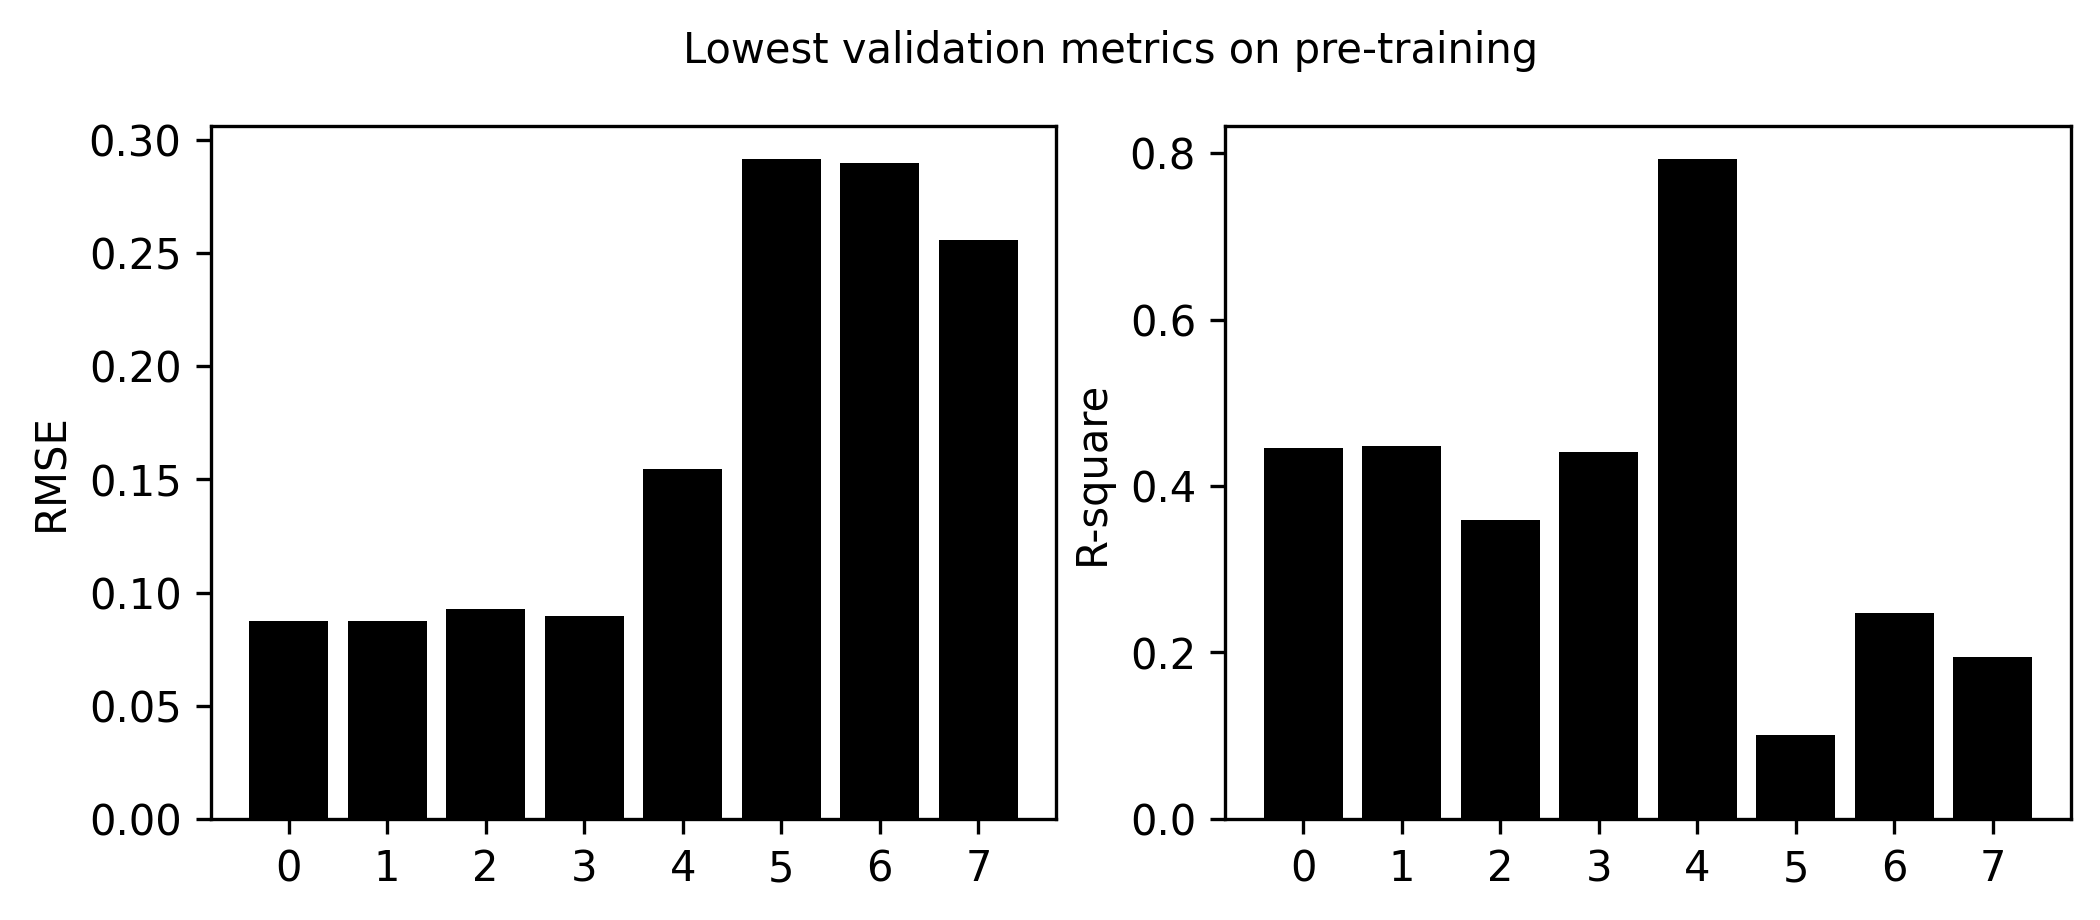

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

axes[0].bar(summary.index, summary['val_rmse'], color='k')
axes[0].set_xticks(summary.index)
axes[0].set_ylabel('RMSE')

axes[1].bar(summary.index, summary['val_r2'], color='k')
axes[1].set_xticks(summary.index)
axes[1].set_ylabel('R-square')

fig.text(0.5, 0.95, 'Lowest validation metrics on pre-training', ha='center', fontsize=10)

plt.show()

## Finetuning

In [8]:
data_loader = build_loader('./data/precords/catalina/fold_0/catalina/', 
                           config, 
                           batch_size=2000, 
                           normalize='zero-mean', 
                           sampling=False,
                           repeat=1,
                           old_version=False)

[INFO] Probed: 0.10 Random: 0.15 Same: 0.15
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Probed: 0.10 Random: 0.15 Same: 0.15
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking


In [9]:
config_list = []
for curr_path in paths:            
    model, config = load_pt_model(os.path.join(curr_path, 'pretraining'))
    model.compile(optimizer='adam')
    try:
        loss, r2, rmse = model.evaluate(data_loader['validation'].take(2))
    except:
        loss, rmse, r2, p = model.evaluate(data_loader['validation'].take(2))
        
    config['val_rmse'] = rmse
    config['val_r2'] = r2
    config_list.append(config)

[INFO] Loading BASE
[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only
[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only
[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only
[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only
3/3 [==============================] - 2s 451ms/step - loss: 0.2454 - r_square: -0.8356 - rmse: 0.2454 - p: 0.8868
[INFO] Loading BASE
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
3/3 [==============================] - 2s 375ms/step - loss: 0.1724 - r_square: 0.1138 - rmse: 0.1724 - p: 0.5883
[INFO] Loading BASE
[INFO] No mask, just logits
[INFO] No mask, just logits
[INFO] No mask, just logits
[INFO] No mask, just logits
3/3 [==============================] - 2s 431ms/step - loss: 0.2177 - r_square: -0.3071 - rmse: 0.2177 - p: 0.8486
[INFO] Loading BASE
[INFO] Temperature: 0.50
[INFO] Masking Keys tokens only
[INFO] Temperature: 0.50
[INFO] Masking Keys tokens

2024-07-16 14:20:41,020 - WARNING - Inconsistent references when loading the checkpoint into this object graph. For example, in the saved checkpoint object, `model.layer.weight` and `model.layer_copy.weight` reference the same variable, while in the current object these are two different variables. The referenced variables are:(<src.models.astromer_0.Encoder object at 0x7f1b5c059b20> and <src.models.astromer_0.RegLayer object at 0x7f1aa05f1970>).


[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
3/3 [==============================] - 2s 135ms/step - loss: 0.3416 - r_square: -2.3595 - rmse: 0.3416
[INFO] Loading BASE
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
3/3 [==============================] - 2s 449ms/step - loss: 0.5527 - r_square: -8.4152 - rmse: 0.5527 - p: 0.9924
[INFO] Loading BASE
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
3/3 [==============================] - 2s 439ms/step - loss: 0.7257 - r_square: -14.3143 - rmse: 0.7257 - p: 0.9671
[INFO] Loading BASE
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
3/3 [==============================] - 2s 350ms/step - loss: 1.2494 - r_square: -46.4886 - rmse: 1.2494 - p: 0.9772


In [10]:
summary = pd.DataFrame(config_list)
summary = summary[['exp_name', 'lr', 'mask_format', 'temperature', 'probed', 'val_rmse', 'val_r2']]
summary

,exp_name,lr,mask_format,temperature,probed,val_rmse,val_r2
0,maogat,0.00001,K,0.8,0.3,0.888494,-0.845120
1,maogat,0.00001,K,0.0,0.3,0.583524,0.127676
2,maogat,0.00001,logits,0.0,0.3,0.845052,-0.298299
3,maogat,0.00001,K,0.5,0.3,0.796706,-0.108507
4,zero,0.00100,QK,0.0,0.5,0.344559,-2.410071
5,classic,0.00001,K,0.0,0.3,0.990068,-8.467322
6,classic,0.00001,K,0.0,0.5,0.963292,-14.388749
7,classic,0.00001,K,0.0,0.1,0.971830,-45.903099


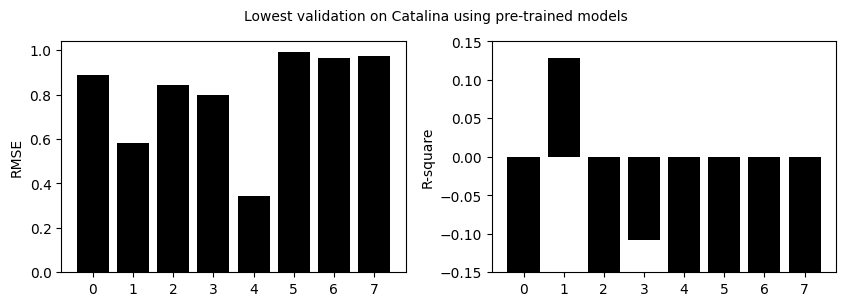

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'wspace':0.25})

axes[0].bar(summary.index, summary['val_rmse'], color='k')
axes[0].set_xticks(summary.index)
axes[0].set_ylabel('RMSE')

axes[1].bar(summary.index, summary['val_r2'], color='k')
axes[1].set_xticks(summary.index)
axes[1].set_ylabel('R-square')
axes[1].set_ylim(-0.15, 0.15)
fig.text(0.5, 0.95, 'Lowest validation on Catalina using pre-trained models', ha='center', fontsize=10)

plt.show()

## Loading downstream data

In [59]:
model_paths = glob.glob(os.path.join('./presentation/results/', '*', '*'))
model_paths

features_spec = ['arch', 'data', 'temperature', 'mask_format']

In [60]:
def get_info_from_path(path, clf=False):
    factors = curr.split('/')
    try:
        info = {
            'ds_name': factors[6],
            'fold_n': int(factors[7].split('_')[-1]),
            'spc': int(factors[8].split('_')[-1]),
            'factors': factors[9] if clf else None
        }
    except:
        info = {
            'ds_name': 'catalina',
            'fold_n': 0,
            'spc': 1000,
            'factors': 'avg_mlp'
        }
    return info

In [61]:
classification_stats = []
for m in model_paths:
    experiments = glob.glob(os.path.join(m, 'classification', 'catalina', '*', '*','*'))
    for curr in experiments:
        info = get_info_from_path(curr, clf=True)
        foo = os.path.join(curr, 'config.toml')
        with open(foo, 'r') as h:
            config = toml.load(h)
            spec = {k:config[k] for k in features_spec}
        
        with open(os.path.join(curr, 'test_metrics.toml'), 'r') as h:
            metrics = toml.load(h)
            for k in metrics:
                metrics[k] = float(metrics[k])

        combined = {**info, **spec, **metrics, **config}
        classification_stats.append(combined)

In [63]:
clf_stats = pd.DataFrame(classification_stats)
clf_stats['mask_format']

0         K
1         K
2    logits
3         K
4        QK
5         K
6         K
7         K
Name: mask_format, dtype: object

In [64]:
clf_stats_mean = clf_stats.groupby(features_spec+['ds_name', 'spc', 'factors'])['test_f1'].mean()
clf_stats_std = clf_stats.groupby(features_spec+['ds_name', 'spc', 'factors'])['test_f1'].std()
clf_stats_mean = clf_stats_mean.reset_index()
clf_stats_std = clf_stats_std.reset_index()

2024-07-16 16:22:28,239 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

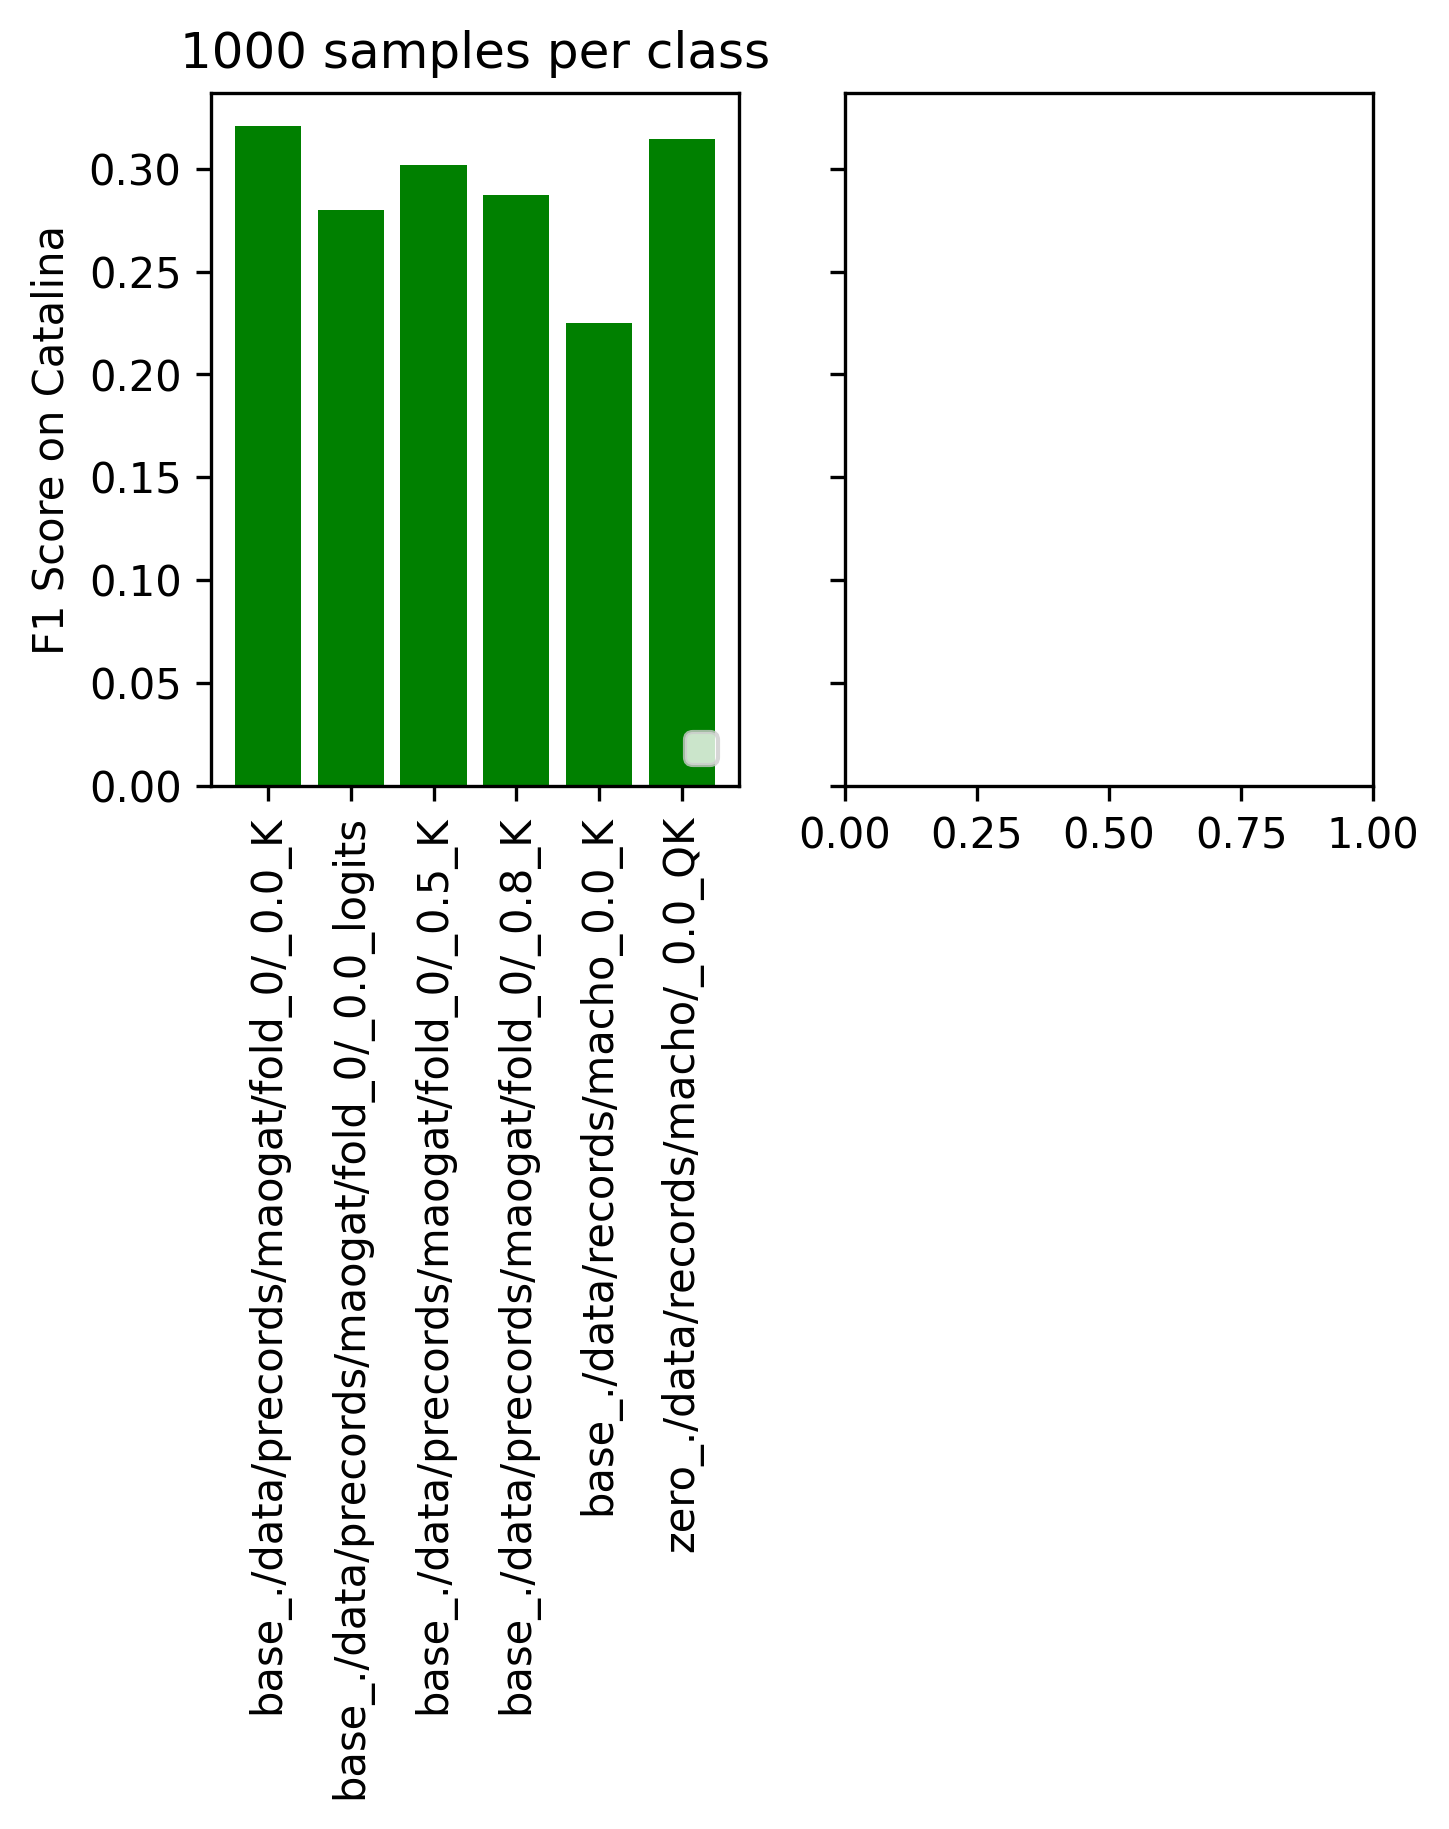

In [66]:
for ds, ds_name in zip(['catalina'], ['Catalina']):
    plt.clf()
    fig, axes = plt.subplots(1, 2, figsize=(5, 3), 
                             sharey=True, 
                             dpi=300)
    for i, spcc in enumerate([1000]):
        sel = clf_stats_mean[(clf_stats_mean['ds_name']==ds) & \
                             (clf_stats_mean['spc']==spcc) & \
                             (clf_stats_mean['factors']== 'avg_mlp')]
        
        sel_std = clf_stats_std[(clf_stats_mean['ds_name']==ds) & \
                             (clf_stats_mean['spc']==spcc) & \
                             (clf_stats_mean['factors']== 'avg_mlp')]
        
        
        sel['label'] = sel.apply(lambda x: get_label(x, features_spec), axis=1)

        axes[i].bar(range(len(sel.index)), sel['test_f1'], color='green')
        axes[i].set_xticks(range(len(sel.index)))
        axes[i].set_xticklabels(sel['label'], rotation=90)
        axes[i].set_title('{} samples per class'.format(spcc))
        axes[i].set_ylabel('F1 Score on {}'.format(ds_name))
#         axes[i].axhline(zero_alcock[str(spcc)],color='red', ls='--', label='AstromerV0')
        axes[i].legend(loc='lower right')
    plt.show()